In [ ]:
!pip install quandl
# Import quandl package
import quandl
import numpy as np
print("Quandl package imported.")

Quandl package imported.


In [ ]:
quandl.ApiConfig.api_key = "Gjm_rdSpznk5zDwN89TH"

In [ ]:
#Downloading financial data
data = quandl.get_table('WIKI/PRICES',
                        ticker='AAPL', 
                        qopts={'columns':['date','close']},
                        paginate=True)

In [ ]:
data.sort_values(by='date',ascending=True).reset_index(drop=True)

,date,close
0,1980-12-12,28.750
1,1980-12-15,27.250
2,1980-12-16,25.250
3,1980-12-17,25.870
4,1980-12-18,26.630
...,...,...
9395,2018-03-21,171.270
9396,2018-03-22,168.845
9397,2018-03-23,164.940
9398,2018-03-26,172.770


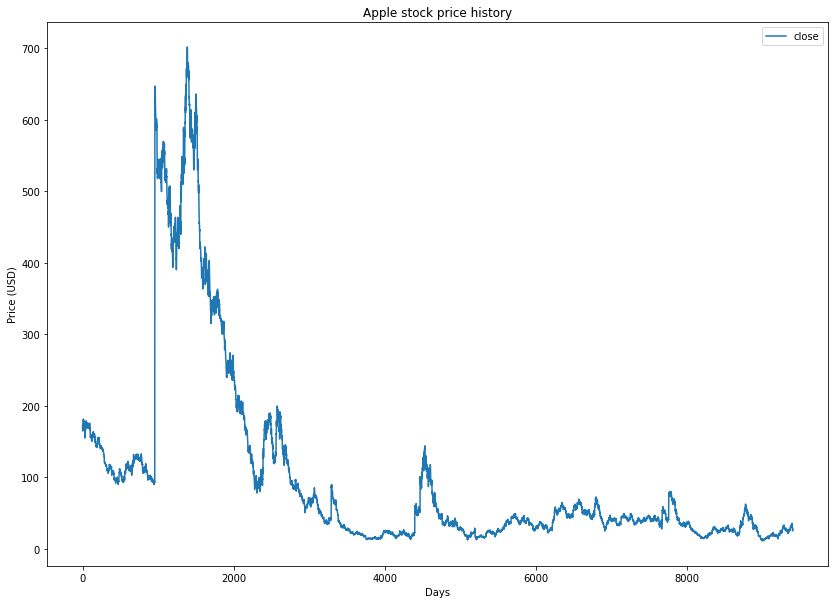

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,10))
plt.plot(data["close"])
plt.title('Apple stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['close'], loc='upper right')
plt.show()

In [ ]:
data.isna().sum()

date     0
close    0
dtype: int64

In [ ]:
batch_size = 200
epochs = 20
timesteps = 40

In [ ]:
def get_train_length(dataset, batch_size, test_percent):
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [ ]:
length = get_train_length(data, batch_size, 0.1)
print(length)

8400
8400


In [ ]:
upper_train = length + timesteps*2
data_train = data[0:upper_train]
training_set = data_train.iloc[:,1:2].values
training_set.shape

(8480, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(8480, 1)

In [ ]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

8440


In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(8400, 40, 1)
(8400, 40, 1)


In [ ]:
from keras.layers import Dense ,Dropout
from keras.layers import Input, LSTM
from keras.models import Model

In [ ]:
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
#each layer is the input of the next layer
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
dropout_layer = Dropout(0.2)(lstm_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(dropout_layer)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(200, 40, 1)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (200, 40, 10)             480       
_________________________________________________________________
dropout_5 (Dropout)          (200, 40, 10)             0         
_________________________________________________________________
lstm_11 (LSTM)               (200, 40, 10)             840       
_________________________________________________________________
dense_5 (Dense)              (200, 40, 1)              11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [ ]:
regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)

Epoch 1/20
42/42 [==============================] - 1s 24ms/step - loss: 0.1292
Epoch 2/20
42/42 [==============================] - 1s 27ms/step - loss: 0.0963
Epoch 3/20
42/42 [==============================] - 1s 23ms/step - loss: 0.0618
Epoch 4/20
42/42 [==============================] - 1s 23ms/step - loss: 0.0358
Epoch 5/20
42/42 [==============================] - 1s 22ms/step - loss: 0.0369
Epoch 6/20
42/42 [==============================] - 1s 23ms/step - loss: 0.0319
Epoch 7/20
42/42 [==============================] - 1s 22ms/step - loss: 0.0342
Epoch 8/20
42/42 [==============================] - 1s 22ms/step - loss: 0.0321
Epoch 9/20
42/42 [==============================] - 1s 22ms/step - loss: 0.0323
Epoch 10/20
42/42 [==============================] - 1s 22ms/step - loss: 0.0317
Epoch 11/20
42/42 [==============================] - 1s 24ms/step - loss: 0.0315
Epoch 12/20
42/42 [==============================] - 1s 23ms/step - loss: 0.0315
Epoch 13/20
42/42 [==================

In [ ]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [ ]:
test_length = get_test_length(data, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

9280
9280
800


In [ ]:
#subsetting
df_data_1_test = data[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_test.shape

(800, 40, 1)

In [ ]:
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(800, 40, 1)
(800, 40)
(760, 1)


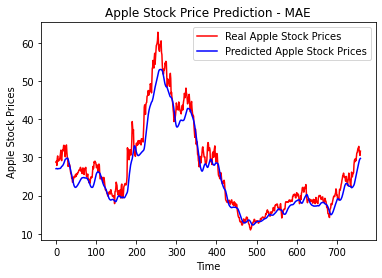

In [ ]:
plt.plot(test_set[timesteps:len(y_test)+timesteps].astype(float), color = 'red', label = 'Real Apple Stock Prices')
plt.plot(y_test.astype(float), color = 'blue', label = 'Predicted Apple Stock Prices')
plt.title('Apple Stock Price Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Apple Stock Prices')
plt.legend()
plt.show()